In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from gensim import corpora, models, matutils
from sklearn.metrics import pairwise_distances
import spacy

In [2]:
rest_data = pd.read_pickle("./restaurant_df.pkl")

In [3]:
rest_data.head()

,Place,Address,Lat,Long,Business_Status,Dine-In,Price_Level,Rating,Total_Ratings,Reviews,URL,dup_check
0,Zuni Café,"1658 Market St, San Francisco, CA 94102, USA",37.773610,-122.421622,OPERATIONAL,True,3,4.4,1920,"[{'author_name': 'Hayley Mitchell', 'author_ur...",https://maps.google.com/?cid=11491213088621274249,"Zuni Café1658 Market St, San Francisco, CA 941..."
1,Brenda's French Soul Food,"652 Polk St, San Francisco, CA 94102, USA",37.782913,-122.418899,OPERATIONAL,True,2,4.5,5014,"[{'author_name': 'Cara S', 'author_url': 'http...",https://maps.google.com/?cid=12074054251018812705,"Brenda's French Soul Food652 Polk St, San Fran..."
2,Absinthe Brasserie & Bar,"398 Hayes St, San Francisco, CA 94102, USA",37.777143,-122.422813,OPERATIONAL,True,3,4.4,1553,"[{'author_name': 'Willa Cai', 'author_url': 'h...",https://maps.google.com/?cid=6425557835396706278,"Absinthe Brasserie & Bar398 Hayes St, San Fran..."
3,Jasper's Corner Tap and Kitchen,"401 Taylor St, San Francisco, CA 94102, USA",37.786119,-122.411510,OPERATIONAL,True,2,3.8,656,"[{'author_name': 'Joel Headley', 'author_url':...",https://maps.google.com/?cid=8430718704283740438,"Jasper's Corner Tap and Kitchen401 Taylor St, ..."
4,Bar Agricole,"1540 Mission St, San Francisco, CA 94103, USA",37.773982,-122.418384,OPERATIONAL,True,3,4.3,494,"[{'author_name': 'Stelios Serghiou', 'author_u...",https://maps.google.com/?cid=15306146528879153507,"Bar Agricole1540 Mission St, San Francisco, CA..."


In [4]:
#df['Business_Status'].value_counts()
rest_data = rest_data[rest_data['Business_Status']=='OPERATIONAL']

In [5]:
#Checking for duplicates
rest_data.drop_duplicates(['dup_check'], inplace=True)

In [6]:
rest_data.reset_index(drop=True, inplace=True)
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Place            190 non-null    object 
 1   Address          190 non-null    object 
 2   Lat              190 non-null    float64
 3   Long             190 non-null    float64
 4   Business_Status  190 non-null    object 
 5   Dine-In          190 non-null    object 
 6   Price_Level      190 non-null    object 
 7   Rating           190 non-null    object 
 8   Total_Ratings    190 non-null    object 
 9   Reviews          190 non-null    object 
 10  URL              190 non-null    object 
 11  dup_check        190 non-null    object 
dtypes: float64(2), object(10)
memory usage: 17.9+ KB


In [7]:
def process_reviews(reviews):
    
    if reviews == 'None':
        all_reviews = 'None'
    else:
        all_reviews = ''
        for review in reviews:
            text = review["text"].lower()
            text = re.sub(r'[^\w\s]', '', text)
            text = re.sub(r'[\r\n]', ' ', text)

            all_reviews = all_reviews + " " + text
        
    return all_reviews
        
def tokenizer(text, min_words = 5,lemmatize=True):
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(w) for w in word_tokenize(text)]
        
    else:
        tokens = [w for w in word_tokenize(text)]
        
    tokens_sw = [w for w in tokens if (len(w)> min_words and w not in stopwords.words())]
    
    return tokens_sw

In [8]:
rest_data['text_reviews'] = rest_data['Reviews'].apply(lambda x:process_reviews(x))

In [9]:
#Adding Tokenized and Lemmatized reviews to df
rest_data["final_reviews"] = rest_data["text_reviews"].apply(lambda x:tokenizer(x))

In [10]:
rest_data.head()

,Place,Address,Lat,Long,Business_Status,Dine-In,Price_Level,Rating,Total_Ratings,Reviews,URL,dup_check,text_reviews,final_reviews
0,Zuni Café,"1658 Market St, San Francisco, CA 94102, USA",37.773610,-122.421622,OPERATIONAL,True,3,4.4,1920,"[{'author_name': 'Hayley Mitchell', 'author_ur...",https://maps.google.com/?cid=11491213088621274249,"Zuni Café1658 Market St, San Francisco, CA 941...",this iconic eatery really lived up to its hyp...,"[iconic, eatery, friendly, attentive, looked, ..."
1,Brenda's French Soul Food,"652 Polk St, San Francisco, CA 94102, USA",37.782913,-122.418899,OPERATIONAL,True,2,4.5,5014,"[{'author_name': 'Cara S', 'author_url': 'http...",https://maps.google.com/?cid=12074054251018812705,"Brenda's French Soul Food652 Polk St, San Fran...",so good we went twice in one week after a rec...,"[recommendation, barista, walked, brendas, bru..."
2,Absinthe Brasserie & Bar,"398 Hayes St, San Francisco, CA 94102, USA",37.777143,-122.422813,OPERATIONAL,True,3,4.4,1553,"[{'author_name': 'Willa Cai', 'author_url': 'h...",https://maps.google.com/?cid=6425557835396706278,"Absinthe Brasserie & Bar398 Hayes St, San Fran...",wonderful drinks food and a très français exp...,"[wonderful, français, experience, outdoor, sea..."
3,Jasper's Corner Tap and Kitchen,"401 Taylor St, San Francisco, CA 94102, USA",37.786119,-122.411510,OPERATIONAL,True,2,3.8,656,"[{'author_name': 'Joel Headley', 'author_url':...",https://maps.google.com/?cid=8430718704283740438,"Jasper's Corner Tap and Kitchen401 Taylor St, ...",coming into the restaurant was great their ta...,"[coming, restaurant, decorated, rosemary, cont..."
4,Bar Agricole,"1540 Mission St, San Francisco, CA 94103, USA",37.773982,-122.418384,OPERATIONAL,True,3,4.3,494,"[{'author_name': 'Stelios Serghiou', 'author_u...",https://maps.google.com/?cid=15306146528879153507,"Bar Agricole1540 Mission St, San Francisco, CA...",highly recommended our rum and bourbonbased c...,"[highly, recommended, bourbonbased, cocktail, ..."


#### Add New column for weighted ratings based on Bayesian Average

In [11]:
final_df = rest_data[['Place','Price_Level','Rating','Total_Ratings','text_reviews','final_reviews']]
final_df = final_df.set_index('Place')

In [12]:
final_df.head()

,Price_Level,Rating,Total_Ratings,text_reviews,final_reviews
Place,,,,,
Zuni Café,3,4.4,1920,this iconic eatery really lived up to its hyp...,"[iconic, eatery, friendly, attentive, looked, ..."
Brenda's French Soul Food,2,4.5,5014,so good we went twice in one week after a rec...,"[recommendation, barista, walked, brendas, bru..."
Absinthe Brasserie & Bar,3,4.4,1553,wonderful drinks food and a très français exp...,"[wonderful, français, experience, outdoor, sea..."
Jasper's Corner Tap and Kitchen,2,3.8,656,coming into the restaurant was great their ta...,"[coming, restaurant, decorated, rosemary, cont..."
Bar Agricole,3,4.3,494,highly recommended our rum and bourbonbased c...,"[highly, recommended, bourbonbased, cocktail, ..."


In [13]:
final_df.to_pickle('./reviews.pkl')

In [14]:
reviews_df = pd.read_pickle('./reviews.pkl')

### Recommender #1 : Content-Based Filtering with TFIDF

In [15]:
def recommend_tfidf(liked_review, matrix, topk=5):
    tokens_liked = [str(w) for w in tokenizer(liked_review)]
    vector_liked = vectorizer.transform(tokens_liked)
    
    cos_mat = cosine_similarity(vector_liked, matrix)
    cos_avg = np.mean(cos_mat, axis=0) 
    
    index = np.argsort(cos_avg)[::-1]
    best_index = index[:topk]
    
    return best_index

In [16]:
vectorizer = TfidfVectorizer(stop_words="english")

### Recommender #2 : Content Based Filtering with Spacy

In [17]:
def recommend_spacy(model, liked_review, reviews, topk=5):
    nlp_review = model(liked_review)

    cos_mat = np.array([nlp_review.similarity(line) for line in reviews])
    index = np.argsort(cos_mat)[::-1]
    best_index = index[:topk]

    return best_index

In [18]:
nlp = spacy.load("en_core_web_sm") 

### Recommender #3 : Topic Modeling + Recommender 

In [19]:
count_vec = CountVectorizer(stop_words = 'english')
count_matrix = count_vec.fit_transform(reviews_df['text_reviews'].values)

In [20]:
count_matrix.shape

(190, 5357)

In [21]:
term_doc = count_matrix.transpose()
corpus = matutils.Sparse2Corpus(term_doc)
id2word = dict((v,k) for k,v in count_vec.vocabulary_.items())
lda = models.LdaModel(corpus = corpus, num_topics = 10, id2word=id2word, passes=500, random_state=43, minimum_probability=0)

In [22]:
lda.print_topics()

[(0,
  '0.018*"food" + 0.013*"good" + 0.012*"place" + 0.012*"great" + 0.009*"really" + 0.008*"nice" + 0.007*"service" + 0.007*"pizza" + 0.007*"like" + 0.007*"time"'),
 (1,
  '0.021*"food" + 0.018*"great" + 0.016*"good" + 0.012*"place" + 0.008*"service" + 0.006*"really" + 0.006*"time" + 0.006*"delicious" + 0.006*"burger" + 0.006*"nice"'),
 (2,
  '0.011*"great" + 0.011*"food" + 0.009*"service" + 0.008*"place" + 0.007*"delicious" + 0.007*"good" + 0.006*"amazing" + 0.006*"gas" + 0.006*"try" + 0.005*"salad"'),
 (3,
  '0.015*"food" + 0.013*"place" + 0.013*"good" + 0.008*"great" + 0.008*"restaurant" + 0.007*"ordered" + 0.007*"like" + 0.006*"flavor" + 0.006*"just" + 0.005*"got"'),
 (4,
  '0.015*"food" + 0.011*"restaurant" + 0.009*"good" + 0.007*"fish" + 0.007*"service" + 0.007*"time" + 0.005*"great" + 0.005*"like" + 0.005*"order" + 0.004*"just"'),
 (5,
  '0.021*"food" + 0.019*"good" + 0.010*"great" + 0.007*"delicious" + 0.007*"service" + 0.006*"breakfast" + 0.006*"restaurant" + 0.006*"place" +

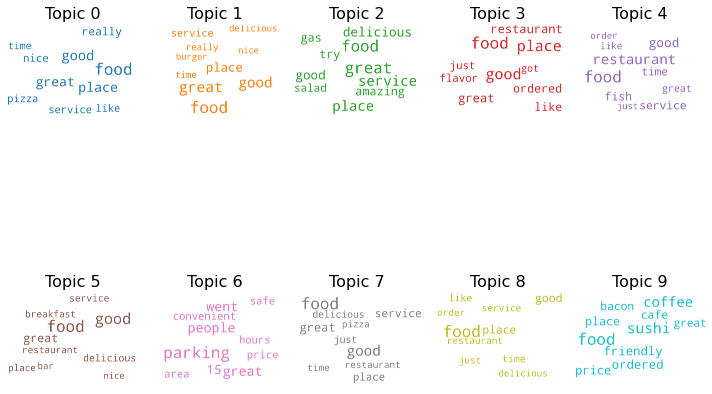

In [23]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords.words('english'),
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [24]:
doc_topic = [doc for doc in lda[corpus]] 


In [25]:
topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10 = [],[],[],[],[],[],[],[],[],[]

for doc in doc_topic:
    topic_1.append(doc[0][1])
    topic_2.append(doc[1][1])
    topic_3.append(doc[2][1])
    topic_4.append(doc[3][1])
    topic_5.append(doc[4][1])
    topic_6.append(doc[5][1])
    topic_7.append(doc[6][1])
    topic_8.append(doc[7][1])
    topic_9.append(doc[8][1])
    topic_10.append(doc[9][1])

In [26]:
reviews_df['topic_1'] = topic_1
reviews_df['topic_2'] = topic_2
reviews_df['topic_3'] = topic_3
reviews_df['topic_4'] = topic_4
reviews_df['topic_5'] = topic_5
reviews_df['topic_6'] = topic_6
reviews_df['topic_7'] = topic_7
reviews_df['topic_8'] = topic_8
reviews_df['topic_9'] = topic_9
reviews_df['topic_10'] = topic_10

In [27]:
reviews_df

,Price_Level,Rating,Total_Ratings,text_reviews,final_reviews,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
Place,,,,,,,,,,,,,,,
Zuni Café,3,4.4,1920,this iconic eatery really lived up to its hyp...,"[iconic, eatery, friendly, attentive, looked, ...",0.000408,0.000408,0.000408,0.000408,0.000408,0.000408,0.226642,0.770091,0.000408,0.000408
Brenda's French Soul Food,2,4.5,5014,so good we went twice in one week after a rec...,"[recommendation, barista, walked, brendas, bru...",0.000562,0.000562,0.000562,0.994942,0.000562,0.000562,0.000562,0.000562,0.000562,0.000562
Absinthe Brasserie & Bar,3,4.4,1553,wonderful drinks food and a très français exp...,"[wonderful, français, experience, outdoor, sea...",0.000991,0.000991,0.000991,0.000991,0.423070,0.000991,0.000990,0.569005,0.000991,0.000991
Jasper's Corner Tap and Kitchen,2,3.8,656,coming into the restaurant was great their ta...,"[coming, restaurant, decorated, rosemary, cont...",0.000495,0.000495,0.000495,0.000495,0.000495,0.995543,0.000495,0.000495,0.000495,0.000495
Bar Agricole,3,4.3,494,highly recommended our rum and bourbonbased c...,"[highly, recommended, bourbonbased, cocktail, ...",0.995542,0.000495,0.000495,0.000495,0.000495,0.000495,0.000495,0.000495,0.000495,0.000495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mandala Indian Cuisine,2,4.4,150,amazing authentic indian taste the place was ...,"[amazing, authentic, indian, hygienic, server,...",0.001088,0.001087,0.001087,0.001087,0.001087,0.001088,0.001087,0.001088,0.990213,0.001087
Pisco Bar,none,4,5,we went to the grand opening of pisco bar hug...,"[opening, mistake, walked, hostess, simply, de...",0.000486,0.000486,0.000486,0.000486,0.000486,0.000486,0.000486,0.000486,0.995629,0.000486
Sipan Peruvian Restaurant & Bar,3,4.2,494,it was a nice meal over all the restaurant wa...,"[restaurant, window, ordered, appetizer, cours...",0.000508,0.000508,0.000508,0.955946,0.000508,0.000508,0.000508,0.039991,0.000508,0.000508


In [55]:
def recommend_lda(liked, matrix, topk=5):
    cos_mat = cosine_similarity(liked.values.reshape(1, -1), matrix)
    cos_avg = np.mean(cos_mat, axis=0) 
    
    index = np.argsort(cos_avg)[::-1]
    best_index = index[:topk]
    
    return best_index

## Evaluating Models

In [29]:
reviews_df['Price_Level'] = pd.to_numeric(reviews_df['Price_Level'], errors='coerce')
reviews_df['Rating'] = pd.to_numeric(reviews_df['Rating'], errors='coerce')
reviews_df['Total_Ratings'] = pd.to_numeric(reviews_df['Total_Ratings'], errors='coerce')

In [30]:
reviews_df['Price_Level'] = reviews_df['Price_Level'].fillna(round(reviews_df['Price_Level'].mean()))
reviews_df['Total_Ratings'] = reviews_df['Total_Ratings'].fillna(round(reviews_df['Total_Ratings'].mean()))
reviews_df['Rating'] = reviews_df['Rating'].fillna(reviews_df['Rating'].mean())

In [43]:
#Split into test-train with a test set = 1% 
test_df = reviews_df.sample(frac = 0.1)
train_df = reviews_df.drop(test_df.index)

liked_idx = np.random.randint(0,6)
liked_review = test_df.iloc[liked_idx,3]

In [44]:
test_df.iloc[liked_idx]

Price_Level                                                    2.0
Rating                                                         4.2
Total_Ratings                                                683.0
text_reviews      we came during pride weekend they were really...
final_reviews    [weekend, attentive, seating, timely, manner, ...
topic_1                                                   0.000622
topic_2                                                   0.000621
topic_3                                                   0.000621
topic_4                                                   0.000621
topic_5                                                   0.000621
topic_6                                                   0.000621
topic_7                                                   0.000621
topic_8                                                   0.994407
topic_9                                                   0.000621
topic_10                                                  0.00

#### TFIDF

In [45]:
matrix = vectorizer.fit_transform(train_df['text_reviews'].values)
tfidf_best_index = recommend_tfidf(liked_review, matrix)
display(train_df.iloc[tfidf_best_index])

,Price_Level,Rating,Total_Ratings,text_reviews,final_reviews,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
Place,,,,,,,,,,,,,,,
Bella Saratoga,3.0,4.3,475.0,absolutely delicious brunch 5 stars would rec...,"[absolutely, delicious, brunch, recommend, ser...",0.000582,0.000582,0.000582,0.000582,0.000582,0.000582,0.000582,0.994764,0.000582,0.000582
Servino Ristorante,2.0,4.1,185.0,good views of the bay from water side outdoor...,"[outdoor, dining, seating, selection, italian,...",0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.987137,0.001429,0.001429
New Delhi Indian Restaurant,2.0,3.7,670.0,i heard about new delhi restaurant for years ...,"[restaurant, different, social, circle, believ...",0.537128,0.000431,0.000431,0.000431,0.000431,0.000431,0.000431,0.459422,0.000431,0.000431
Sam's Anchor Cafe,2.0,4.3,1146.0,it was a great afternoon treat and it was a g...,"[afternoon, coincidence, restaurant, closed, t...",0.000637,0.000637,0.000637,0.000637,0.613048,0.000637,0.000637,0.381854,0.000637,0.000637
Absinthe Brasserie & Bar,3.0,4.4,1553.0,wonderful drinks food and a très français exp...,"[wonderful, français, experience, outdoor, sea...",0.000991,0.000991,0.000991,0.000991,0.423070,0.000991,0.000990,0.569005,0.000991,0.000991


#### SpaCy

In [46]:
train_df['spacy_reviews'] = train_df['text_reviews'].apply(lambda x: nlp(x)) 
reviews = train_df['spacy_reviews'].values

spacy_best_index = recommend_spacy(nlp, liked_review, reviews)
display(train_df.iloc[spacy_best_index])

/var/folders/zd/hcr0j8s10c52wqddtzbkj5kr0000gn/T/ipykernel_94766/2906440620.py:4: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  cos_mat = np.array([nlp_review.similarity(line) for line in reviews])


,Price_Level,Rating,Total_Ratings,text_reviews,final_reviews,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,spacy_reviews
Place,,,,,,,,,,,,,,,,
Sipan Peruvian Restaurant & Bar,3.0,4.2,494.0,it was a nice meal over all the restaurant wa...,"[restaurant, window, ordered, appetizer, cours...",0.000508,0.000508,0.000508,0.955946,0.000508,0.000508,0.000508,0.039991,0.000508,0.000508,"( , it, was, a, nice, meal, over, all, the, re..."
Fino,2.0,4.6,597.0,this review is for the bar and its delightful...,"[review, delightful, selection, potter, themed...",0.000582,0.000582,0.000582,0.000582,0.628505,0.000582,0.000582,0.366842,0.000582,0.000582,"( , this, review, is, for, the, bar, and, its,..."
La Fondue,4.0,4.4,868.0,im a regular for their groupon le frank deal ...,"[regular, groupon, course, dinner, including, ...",0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.995133,0.000541,"( , i, m, a, regular, for, their, groupon, le,..."
Plumed Horse,4.0,4.4,674.0,wonderful dining experience well worth its mi...,"[wonderful, dining, experience, michelin, extr...",0.000403,0.000403,0.000403,0.000403,0.000403,0.000403,0.000403,0.000403,0.996369,0.000403,"( , wonderful, dining, experience, well, worth..."
John's Grill,3.0,4.3,3006.0,this is a classic and beautiful place to have...,"[classic, beautiful, dinner, restaurant, runni...",0.000372,0.000372,0.000372,0.996653,0.000372,0.000372,0.000372,0.000372,0.000372,0.000372,"( , this, is, a, classic, and, beautiful, plac..."


#### LDA Topic Modeling

In [47]:
#Drop non-numerical columns
lda_test_df = test_df.drop(columns=["text_reviews","final_reviews"])
lda_train_df = train_df.drop(columns=["text_reviews","final_reviews","spacy_reviews"])

liked_rest = lda_test_df.iloc[liked_idx]

In [51]:
lda_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 170 entries, Zuni Café to Big Basin Burger Bar
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Price_Level    170 non-null    float64
 1   Rating         170 non-null    float64
 2   Total_Ratings  170 non-null    float64
 3   topic_1        170 non-null    float32
 4   topic_2        170 non-null    float32
 5   topic_3        170 non-null    float32
 6   topic_4        170 non-null    float32
 7   topic_5        170 non-null    float32
 8   topic_6        170 non-null    float32
 9   topic_7        170 non-null    float32
 10  topic_8        170 non-null    float32
 11  topic_9        170 non-null    float32
 12  topic_10       170 non-null    float32
dtypes: float32(10), float64(3)
memory usage: 12.0+ KB


In [56]:
lda_best_index = recommend_lda(liked_rest,lda_train_df)
display(train_df.iloc[lda_best_index])


,Price_Level,Rating,Total_Ratings,text_reviews,final_reviews,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,spacy_reviews
Place,,,,,,,,,,,,,,,,
"La Boulangerie de San Francisco, Hayes",2.0,4.2,725.0,lovely place the omelettes are of good size ...,"[lovely, omelette, pastry, delicious, highly, ...",0.000681,0.000681,0.000681,0.000681,0.000681,0.000681,0.000681,0.993874,0.000681,0.000681,"( , lovely, place, the, omelettes, are, of, ,..."
Marin Joe's Restaurant,2.0,4.4,731.0,well im going to put 2 stars and its only for...,"[waiter, pretty, picture, shrimp, honest, iceb...",0.000527,0.000527,0.000527,0.000527,0.000527,0.000527,0.000526,0.584510,0.000527,0.411278,"( , well, i, m, going, to, put, 2, stars, and,..."
New Delhi Indian Restaurant,2.0,3.7,670.0,i heard about new delhi restaurant for years ...,"[restaurant, different, social, circle, believ...",0.537128,0.000431,0.000431,0.000431,0.000431,0.000431,0.000431,0.459422,0.000431,0.000431,"( , i, heard, about, new, delhi, restaurant, f..."
Starbucks,2.0,4.2,576.0,the place was empty which is good the attenti...,"[attention, baristas, friendly, manager, frien...",0.000700,0.000700,0.000700,0.000700,0.000700,0.000700,0.000700,0.993702,0.000700,0.000700,"( , the, place, was, empty, which, is, good, t..."
Basil Thai Restaurant & Bar,2.0,4.3,644.0,unappetizing bias its unfortunate this restau...,"[unappetizing, unfortunate, restaurant, differ...",0.000386,0.000386,0.000386,0.000386,0.587466,0.000386,0.000386,0.409444,0.000386,0.000386,"( , unappetizing, bias, its, unfortunate, this..."
